# Scenario Builder

In [1]:
using Pkg;
Pkg.activate("..")

  Activating project at `~/Documents/repos/GatekeeperFormationFlight.jl/examples`


In [2]:
using GatekeeperFormationFlight

In [3]:
using StaticArrays
using YAML

In [114]:
include("./file_util.jl")
include("../3d_example_utils.jl")
include("./demo_util.jl")

Main.DemoUtil

## Create the Obstacles

In [58]:
# Empty Vector of Obstacles
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()

GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[]

In [59]:
obs_1 = Cylinder(1.5, 1.5, 0.5)
obs_2 = Sphere(2.5, 1.5, 1.5, 0.5)
push!(obstacles, obs_1)
push!(obstacles, obs_2)

2-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 Cylinder{Float64}([1.5, 1.5, 0.0], 0.5)
 Sphere{Float64}([2.5, 1.5, 1.5], 0.5)

In [60]:
obstacles_dict = [FileUtil.obstacle_to_dict(obs) for obs in obstacles]

2-element Vector{Dict{String, Any}}:
 Dict("radius" => 0.5, "position" => [1.5, 1.5, 0.0], "type" => "Cylinder")
 Dict("radius" => 0.5, "position" => [2.5, 1.5, 1.5], "type" => "Sphere")

## Create the Gatekeeper Coefficients Object

In [61]:
# Create desired object using kwarg constructor
coeffs = GatekeeperCoefficients(
    switch_step_size = 0.5,
    reconnection_step_size = 0.125,
    max_Ts_horizon = 10.0,
    integration_max_step_size = 0.05,
    integration_step_size = 0.01,
    collision_check_step_size = 0.05
)

# Convert to dictionary with symbol keys
coeffs_dict = Dict(fieldnames(GatekeeperCoefficients) .=> getfield.(Ref(coeffs), fieldnames(GatekeeperCoefficients)))

Dict{Symbol, Float64} with 6 entries:
  :reconnection_step_size    => 0.125
  :max_Ts_horizon            => 10.0
  :integration_step_size     => 0.01
  :collision_check_step_size => 0.05
  :switch_step_size          => 0.5
  :integration_max_step_size => 0.05

## Create the Agent Settings

In [62]:
agent_settings = DemoUtil.AgentSettings(
    v_min = 0.8,
    v_max = 1.0,
    x_padding = 0.1,
    agent_radius = 0.125,
    turn_radius = 0.5,
    pitch_limits = SVector(-pi / 4, pi / 4)
)

agent_settings_dict = Dict(fieldnames(DemoUtil.AgentSettings) .=> getfield.(Ref(agent_settings), fieldnames(DemoUtil.AgentSettings)))

Dict{Symbol, Any} with 6 entries:
  :turn_radius  => 0.5
  :pitch_limits => [-0.785398, 0.785398]
  :v_min        => 0.8
  :v_max        => 1.0
  :x_padding    => 0.1
  :agent_radius => 0.125

## Create the Agent Starting Positions

In [63]:
sim_agents = Vector{DemoUtil.SimAgent}()

Main.DemoUtil.SimAgent[]

In [64]:
agent1 = DemoUtil.SimAgent(
    id = 1,
    offset = SVector(0.0, 0.0, 0.0, 0.0, 0.0)
)
agent2 = DemoUtil.SimAgent(
    id = 2,
    offset = SVector(0.0, 0.0, 1.0, 0.0, 0.0)
)
agent3 = DemoUtil.SimAgent(
    id = 3,
    offset = SVector(0.0, 1.0, 0.0, 0.0, 0.0)
)

push!(sim_agents, agent1)
push!(sim_agents, agent2)
push!(sim_agents, agent3)

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])

In [65]:
sim_agents_out = [Dict(fieldnames(DemoUtil.SimAgent) .=> getfield.(Ref(sim_agent), fieldnames(DemoUtil.SimAgent))) for sim_agent in sim_agents]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:offset => [0.0, 0.0, 0.0, 0.0, 0.0], :id => 1)
 Dict(:offset => [0.0, 0.0, 1.0, 0.0, 0.0], :id => 2)
 Dict(:offset => [0.0, 1.0, 0.0, 0.0, 0.0], :id => 3)

## Create the Scenario

In [66]:
scenario = DemoUtil.SimScenario(
    name = "demo_scenario",
    start_pose = SVector(0.0, 0.0, 0.0, 0.0, 0.0),
    goal_pose = SVector(1.0, 1.0, 1.0, 0.0, 0.0),
    domain_min = SVector(-1.0, -1.0, 0.0), 
    domain_max = SVector(1.0, 1.0, 2.0)
)
scenario_dict = Dict(fieldnames(DemoUtil.SimScenario) .=> getfield.(Ref(scenario), fieldnames(DemoUtil.SimScenario)))

Dict{Symbol, Any} with 5 entries:
  :start_pose => [0.0, 0.0, 0.0, 0.0, 0.0]
  :domain_min => [-1.0, -1.0, 0.0]
  :name       => "demo_scenario"
  :domain_max => [1.0, 1.0, 2.0]
  :goal_pose  => [1.0, 1.0, 1.0, 0.0, 0.0]

## Write YAML

In [67]:
output_object = Dict(
    "gatekeeper_coefficients" => coeffs_dict,
    "obstacles" => obstacles_dict,
    "agent_settings" => agent_settings_dict,
    "agents" => sim_agents_out,
    "scenario" => scenario_dict
)

YAML.write_file("scenarios/$(scenario_dict[:name]).yaml", output_object)


## Load YAML

In [190]:
obj = YAML.load_file("scenarios/demo_scenario.yaml"; dicttype=Dict{Symbol, Any})

Dict{Symbol, Any} with 5 entries:
  :obstacles               => Dict{Symbol, Any}[Dict(:radius=>0.5, :position=>[…
  :gatekeeper_coefficients => Dict{Symbol, Any}(:reconnection_step_size=>0.125,…
  :agent_settings          => Dict{Symbol, Any}(:turn_radius=>0.5, :pitch_limit…
  :agents                  => Dict{Symbol, Any}[Dict(:offset=>[0.0, 0.0, 0.0, 0…
  :scenario                => Dict{Symbol, Any}(:start_pose=>[0.0, 0.0, 0.0, 0.…

In [191]:
coeffs_in = obj[:gatekeeper_coefficients]
gk_coeffs = GatekeeperCoefficients(; coeffs_in...)
obj[:gatekeeper_coefficients] = gk_coeffs

GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5)

In [192]:
objects_in = obj[:obstacles]
objects = [FileUtil.dict_to_obstacle(obs) for obs in objects_in]
obj[:obstacles] = objects

2-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 Cylinder{Float64}([1.5, 1.5, 0.0], 0.5)
 Sphere{Float64}([2.5, 1.5, 1.5], 0.5)

In [193]:
obj[:agent_settings] = DemoUtil.AgentSettings(; obj[:agent_settings]...)

Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483])

In [194]:
obj[:agents] = [DemoUtil.SimAgent(; agent...) for agent in obj[:agents]]

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])

In [195]:
# @show obj[:scenario]
obj[:scenario] = DemoUtil.SimScenario(; obj[:scenario]...)

Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0])

In [196]:
# sim_env = DemoUtil.SimEnvironment(; obj...)
sim_env = DemoUtil.SimEnvironment(; obj...)

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[Cylinder{Float64}([1.5, 1.5, 0.0], 0.5), Sphere{Float64}([2.5, 1.5, 1.5], 0.5)], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5), nothing, nothing, nothing, nothing, nothing)

## Testing with DemoUtil

In [218]:
include("./demo_util.jl")

Main.DemoUtil

In [219]:
env = DemoUtil.load_env("scenarios/demo_scenario.yaml")

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[Cylinder{Float64}([1.5, 1.5, 0.0], 0.5), Sphere{Float64}([2.5, 1.5, 1.5], 0.5)], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5), nothing, nothing, nothing, nothing, nothing)

In [220]:
success = DemoUtil.solve_leader_path!(env)

true

In [221]:
success = DemoUtil.solve_gk_problem!(env)

      Multi-Agent Gatekeeper Simulation        
Number of agents: 3


[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Candidate trajectory found for all agents
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Simulation complete. Returning solution.


true

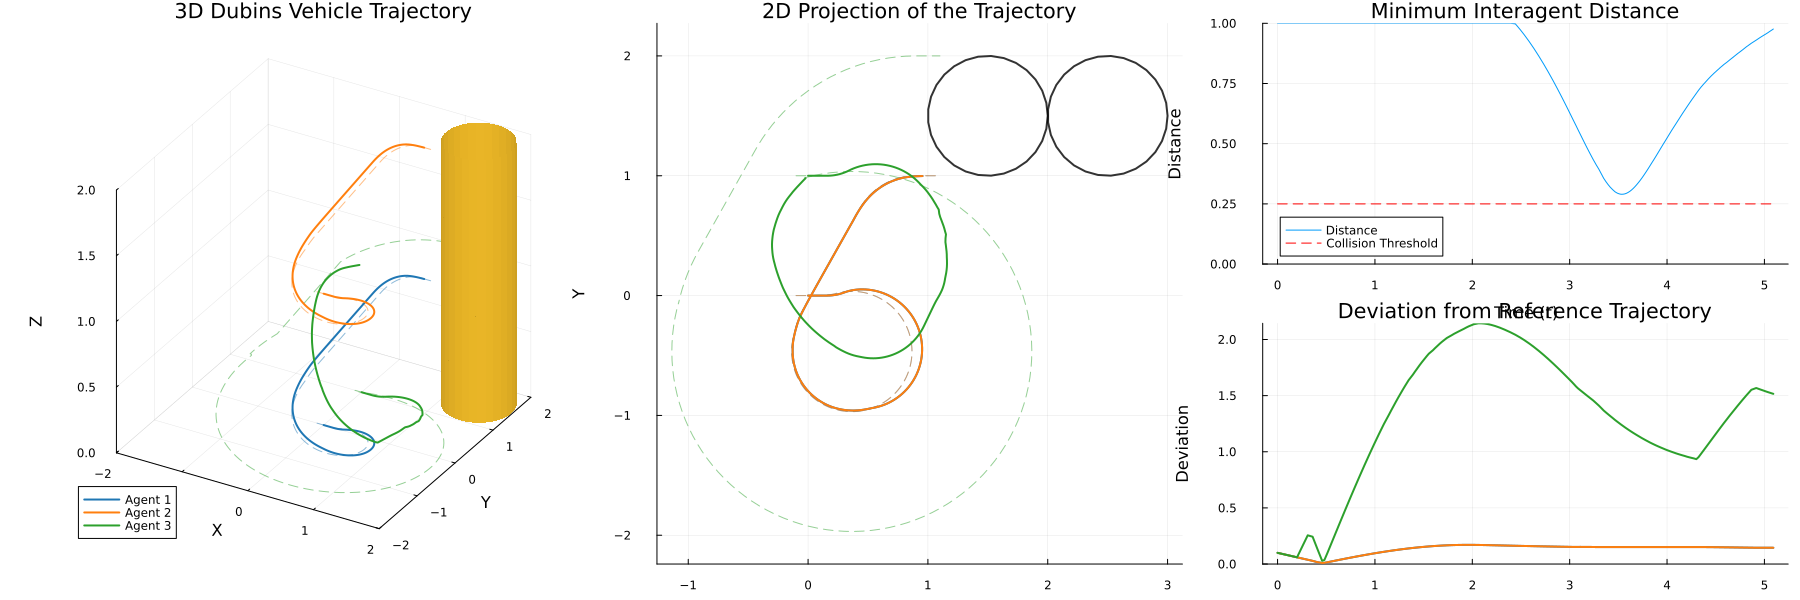

In [222]:
p = ExampleUtils3D.plot_interagent_solution(env.solution, env.gk)
display(p)

### Write Solution to File

In [223]:
DemoUtil.write_to_file(env, "scenarios/demo_scenario_solution.csv")

Row,pos_z,time,pos_y,heading,agent_id,pos_x
,Float64,Float64,Float64,Float64,Int64,Float64
1,0.0,0.0,0.0,0.0,1,0.0
2,1.0,0.0,0.0,0.0,2,0.0
3,0.0,0.0,1.0,0.0,3,0.0
4,0.0,0.00196406,0.0,0.0,1,0.008
5,1.0,0.00196406,0.0,0.0,2,0.008
6,0.0,0.00196406,1.0,0.0,3,0.008
7,0.0,0.00392812,0.0,0.0,1,0.016
8,1.0,0.00392812,0.0,0.0,2,0.016
9,0.0,0.00392812,1.0,0.0,3,0.016


In [224]:
# @show env.solution[:, 1]
# @show env.solution.t
@show env.solution(1.06)

env.solution(1.06) = [0.8733411024459707 -0.17899928085865724 0.03774207689693587 -1.002791718946972 0.0; 0.8733411024459707 -0.17899928085865724 1.0377420768969359 -1.002791718946972 0.0; 0.9125011481905239 0.9552847839435595 0.03783819855665789 -0.7712586623290401 0.0]


3×5 Matrix{Float64}:
 0.873341  -0.178999  0.0377421  -1.00279   0.0
 0.873341  -0.178999  1.03774    -1.00279   0.0
 0.912501   0.955285  0.0378382  -0.771259  0.0

In [225]:
chunk_polys = DemoUtil.fit_polynomials(env.data)

78-element Vector{Any}:
 (agent_id = 1, t_start = 0.0, t_end = 0.7463432939898461, px = Polynomial(-3.185230740090442e-17 + 0.20365963119656463*x - 2.3811116040372588e-14*x^2 + 1.004108992135336e-13*x^3 - 1.6793662896275234e-13*x^4 + 9.662049717415737e-14*x^5), py = Polynomial(0.0), pz = Polynomial(0.0))
 (agent_id = 1, t_start = 0.0, t_end = 0.7463432939898461, px = Polynomial(0.15999660111140945 + 0.203943473989749*x - 0.0035170657621666126*x^2 + 0.00610239671954385*x^3 - 0.025970010957452865*x^4 + 0.015741241655871572*x^5), py = Polynomial(7.950115302957491e-6 - 0.0005797733438994311*x + 0.059966057463169554*x^2 - 0.03476949975507284*x^3 + 0.059143441238346334*x^4 - 0.03627012378193243*x^5), pz = Polynomial(4.1611958682380873e-10 - 2.896039491753779e-8*x + 0.004698698877060611*x^2 + 7.904162583479259e-5*x^3 - 3.997789248535946e-6*x^4 - 2.923381332046552e-7*x^5))
 (agent_id = 1, t_start = 0.0, t_end = 0.746343293989846, px = Polynomial(0.31572118261431814 + 0.20854118866314272*x - 0.

### Plot the Chunk Polynomials

In [226]:
p = plot(legend = false)
for pnom in chunk_polys
    plot!(
        p,
        τ -> pnom.px(τ),
        τ -> pnom.py(τ),
        τ -> pnom.pz(τ),
        [pnom.t_start, pnom.t_end],
    )
end

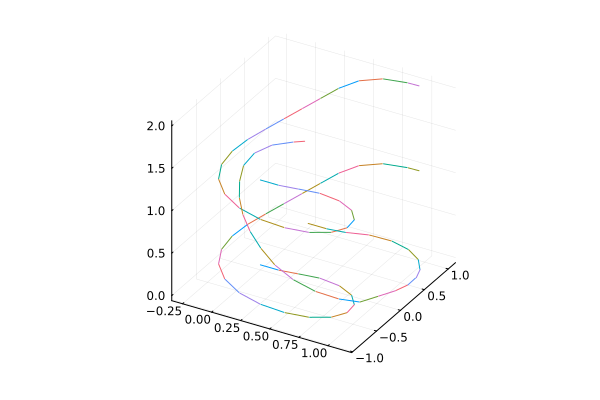

In [227]:
display(p)

### Write the Polynomials to a File

In [ ]:
DemoUtil.write_polynomials_to_file(chunk_polys, "scenarios/$(env.scenario.name)_trajectories.csv")